# Integraded Gradients

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Integrated gradients for regression on the Boston Housing dataset

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import IntegratedGradients

In [3]:
data = load_boston()
feature_names = data.feature_names

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data.data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [5]:
features = scaler.transform(data.data)

In [8]:
features[0]

array([0.        , 0.18      , 0.06781525, 0.        , 0.31481481,
       0.57750527, 0.64160659, 0.26920314, 0.        , 0.20801527,
       0.28723404, 1.        , 0.08967991])

In [9]:
scaler = MinMaxScaler()
scaler.fit(data.target.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
labels = scaler.transform(data.target.reshape(-1,1))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(379, 13) (379, 1) (127, 13) (127, 1)


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)])

2021-10-14 09:34:24.962367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-14 09:34:24.990973: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1497600000 Hz
2021-10-14 09:34:24.992022: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ceeb7a6840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-14 09:34:24.992053: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [17]:
model.build(X_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (379, 10)                 140       
_________________________________________________________________
dense_1 (Dense)              (379, 1)                  11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

In [19]:
%%time
history = model.fit(
    X_train, y_train,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1.87 s, sys: 127 ms, total: 1.99 s
Wall time: 1.67 s


In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.012556,0.012358,95
96,0.012597,0.012229,96
97,0.011978,0.013379,97
98,0.013413,0.017194,98
99,0.013511,0.012367,99


In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

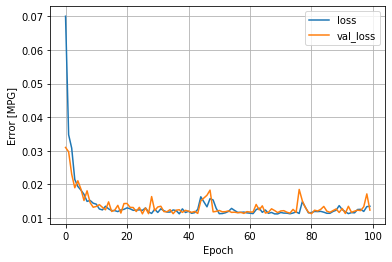

In [22]:
plot_loss(history)

In [23]:
test_results = model.evaluate(X_test, y_test, verbose=0)

In [24]:
print('MSE:', test_results)

MSE: 0.012268215417861938


In [25]:
x_test_sample = X_test[:10]
y = model.predict(x_test_sample)

In [27]:
n_steps = 1000
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model,
                          layer=None,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

In [28]:
x_test_sample = X_test[:nb_samples]
predictions = model(x_test_sample).numpy()
print(predictions)

explanation = ig.explain(x_test_sample,
                         baselines=None,
                         target=predictions,
                         attribute_to_layer_inputs=False)

[[0.532047  ]
 [0.6756232 ]
 [0.20902118]
 [0.43595296]
 [0.27720517]
 [0.3953424 ]
 [0.27689794]
 [0.1881539 ]
 [0.36887434]
 [0.34306434]]


In [29]:
print(x_test_sample[0])
for i in range (10):
    print(np.linalg.norm(x_test_sample[i]))

[9.60549795e-04 0.00000000e+00 1.31598240e-01 0.00000000e+00
 2.57201646e-01 5.47039663e-01 8.36251287e-01 1.37920687e-01
 1.73913043e-01 2.08015267e-01 4.25531915e-01 9.96469817e-01
 2.01710817e-01]
1.5457345466387207
1.756465429049092
2.2870733270446717
1.4368759663026032
2.370049872479209
1.6377520470231293
1.6758283102515237
2.0987660093722686
2.280044285168349
1.72071298610043


In [30]:
# Metadata from the explanation object
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'method': 'gausslegendre',
  'n_steps': 1000,
  'internal_batch_size': 100,
  'layer': 0}}

In [31]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [32]:
explanation.baselines

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [33]:
# Get attributions values from the explanation object
print(len(explanation.attributions))
attrs = explanation.attributions[0]
print('Attributions shape:', attrs.shape)

1
Attributions shape: (10, 13)


In [44]:
baseline = explanation.baselines[0].reshape(1,-1)
print(baseline)
baseline_prediction = model.predict(baseline)
print(baseline_prediction)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.3867394]]


In [46]:
for i in range(len(x_test_sample)):
    x_i = x_test_sample[i]
    attrs_i = attrs[i]
    pred = predictions[i]
    base_pred = pred
    print(i, pred[0], np.sum(attrs_i)-baseline_prediction[0][0])
    #print(np.sum(attrs_i))
    #print(np.sqrt(np.sum(attrs_i)/1.82))

0 0.532047 -0.5320470419517699
1 0.6756232 -0.6756232028675262
2 0.20902118 -0.20902122821869515
3 0.43595296 -0.4359529108891056
4 0.27720517 -0.27720515524911893
5 0.3953424 -0.3953423758216471
6 0.27689794 -0.2768979258747676
7 0.1881539 -0.18815393357628324
8 0.36887434 -0.3688743118166632
9 0.34306434 -0.3430643879480099


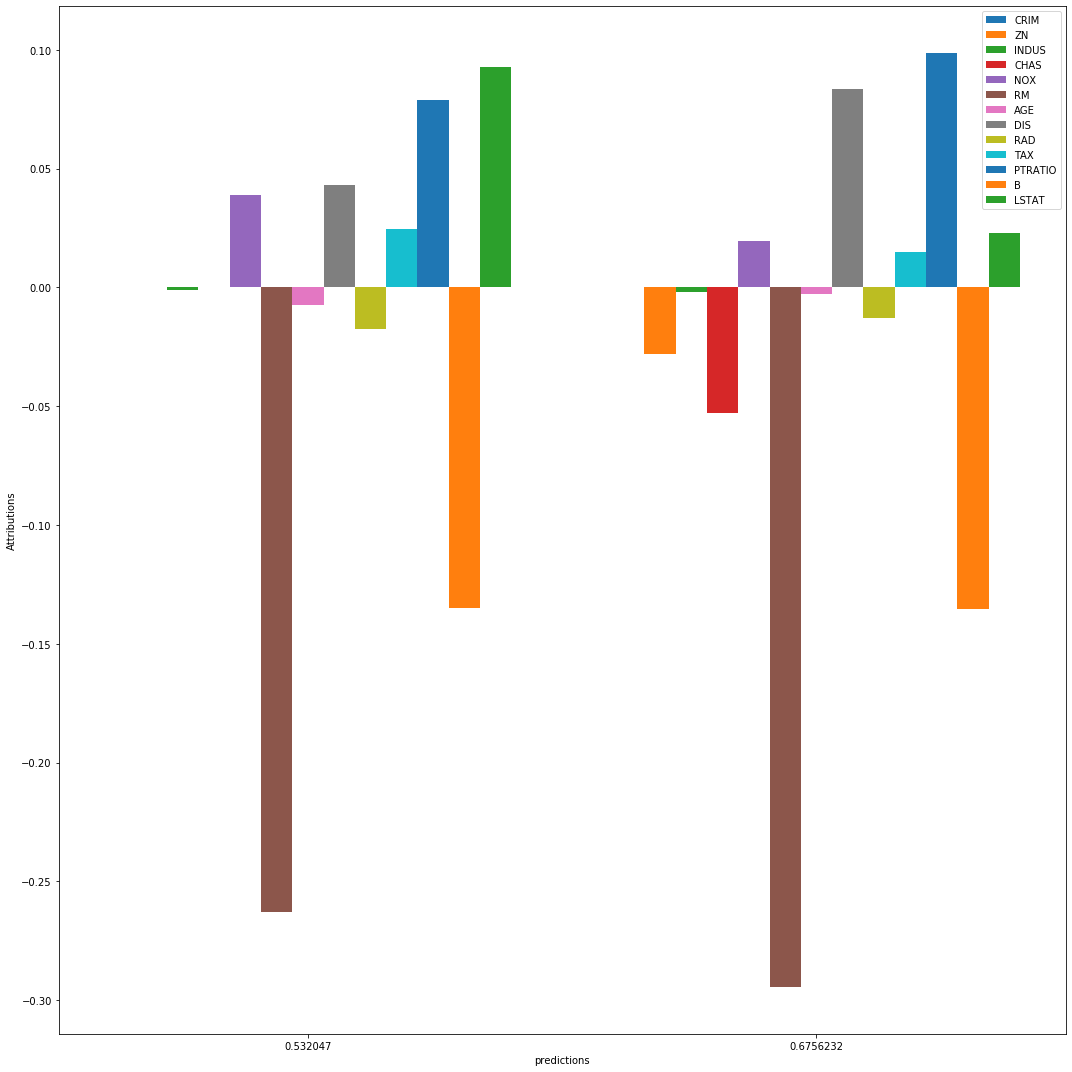

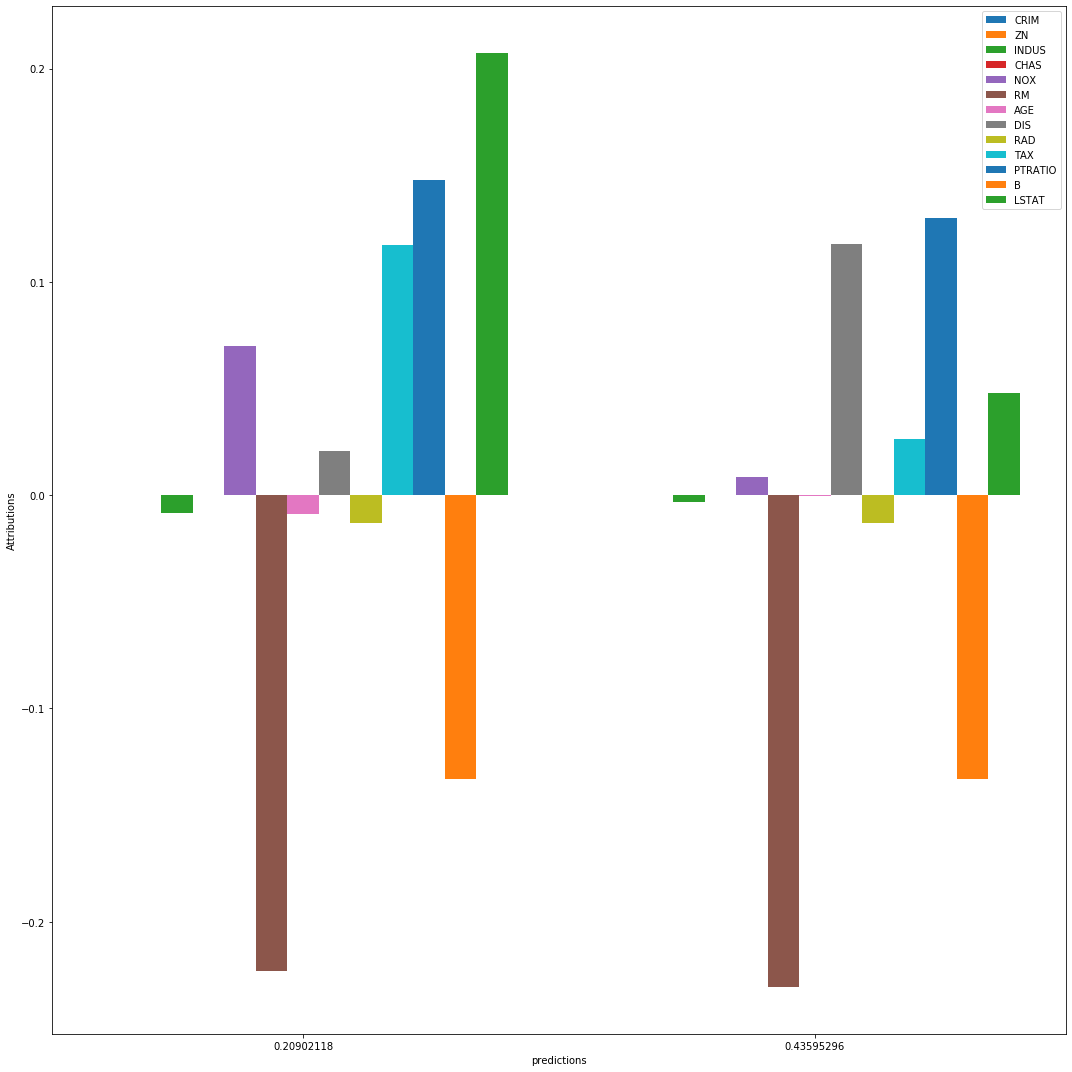

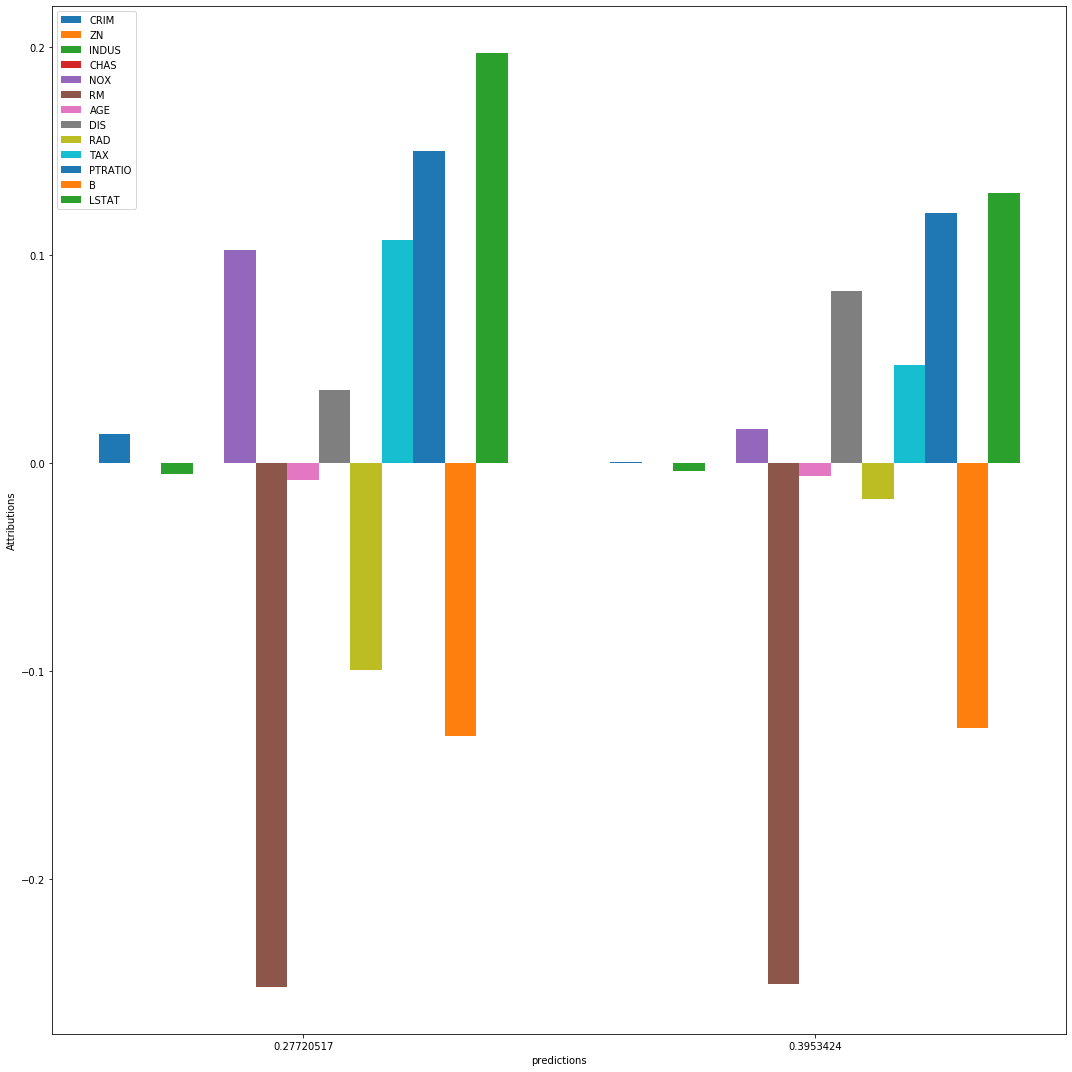

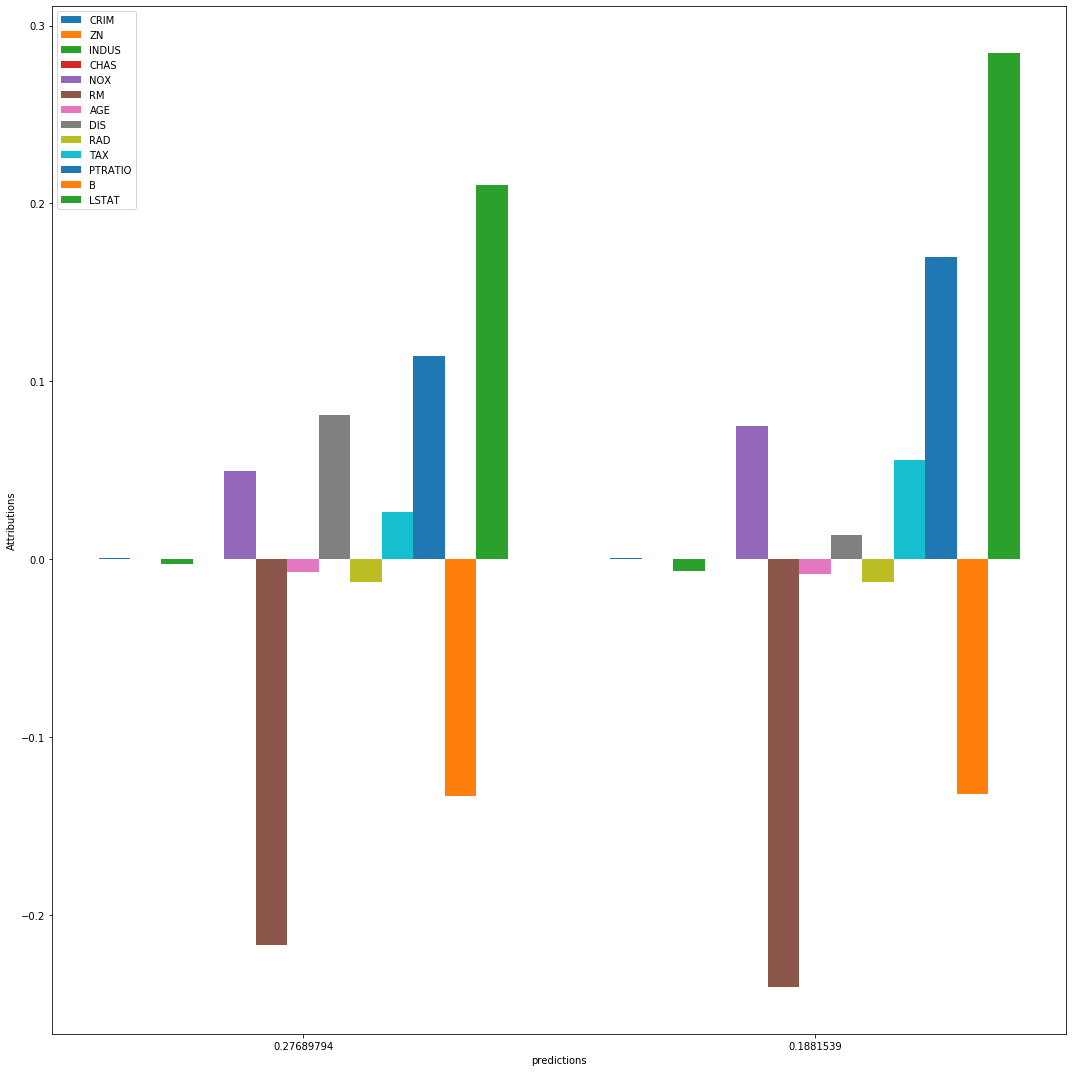

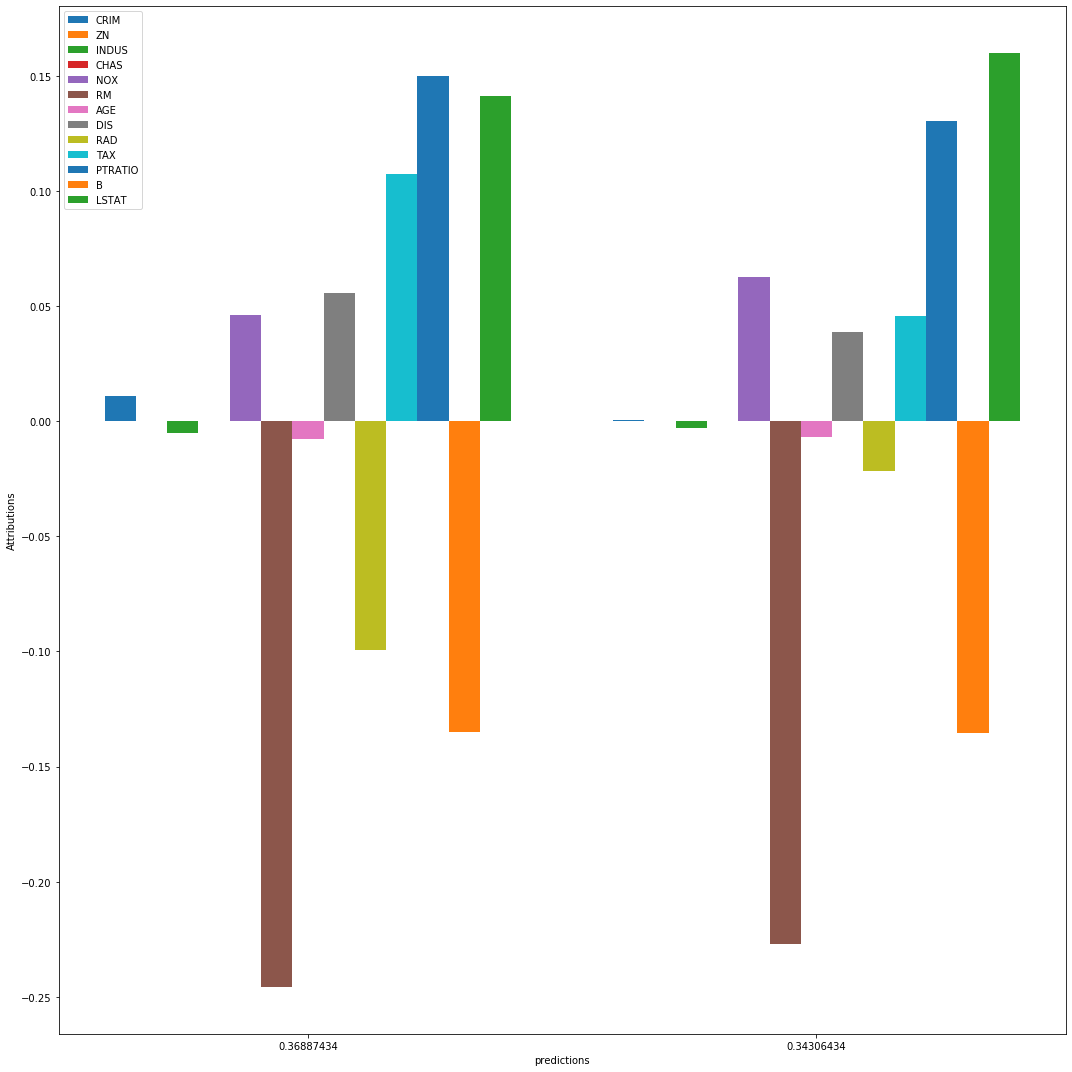

In [50]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

for k in range(0,len(attrs),2):
    n_groups = 2
    index = np.arange(n_groups)
    plt.figure(figsize=(15, 15))
    gap = .8 / len(np.transpose(attrs))
    for i, row in enumerate(np.transpose(attrs[k:k+2])):
        X = np.arange(len(row))
        plt.bar(X + i * gap, row,
        width = gap,
        label= feature_names[i])


    plt.xlabel('predictions')
    plt.ylabel('Attributions')
    plt.xticks(index + gap*6, (predictions[k][0], predictions[k+1][0]))
    plt.legend()

    plt.tight_layout()
    plt.show()

## Integrated gradients for text classification on the IMDB dataset

In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # True

In [2]:
max_features = 10000
maxlen = 100

In [3]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
test_labels = y_test.copy()
train_labels = y_train.copy()
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

index = imdb.get_word_index()
reverse_index = {value: key for (key, value) in index.items()}

Loading data...
17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dsyrrafos/miniconda3/envs/xai/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/dsyrrafos/miniconda3/envs/xai/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
1646592/1641221 [==============================] - 0s 0us/step


In [4]:
def decode_sentence(x, reverse_index):
    # the `-3` offset is due to the special tokens used by keras
    # see https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
    return " ".join([reverse_index.get(i - 3, 'UNK') for i in x])

In [5]:
print(decode_sentence(x_test[1], reverse_index))

a powerful study of loneliness sexual UNK and desperation be patient UNK up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to UNK a strong emotional response from the viewer if you want to see an unusual film some might even say bizarre this is worth the time br br unfortunately it's very difficult to find in video stores you may have to buy it off the internet


In [6]:
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [7]:
load_model = False
save_model = True

In [8]:
filepath = './model_imdb/'  # change to directory where model is downloaded
if load_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    print('Build model...')

    inputs = Input(shape=(maxlen,), dtype=tf.int32)
    embedded_sequences = Embedding(max_features,
                                   embedding_dims)(inputs)
    out = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(embedded_sequences)
    out = Dropout(0.4)(out)
    out = GlobalMaxPooling1D()(out)
    out = Dense(hidden_dims,
                activation='relu')(out)
    out = Dropout(0.4)(out)
    outputs = Dense(2, activation='softmax')(out)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print('Train...')
    model.fit(x_train, y_train,
              batch_size=256,
              epochs=3,
              validation_data=(x_test, y_test))
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

Build model...
Train...
Epoch 1/3


2021-10-08 10:55:57.672159: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-08 10:55:57.691768: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1497600000 Hz
2021-10-08 10:55:57.692124: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564e00c27800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-08 10:55:57.692141: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


98/98 [==============================] - 8s 79ms/step - loss: 0.6022 - accuracy: 0.6549 - val_loss: 0.4157 - val_accuracy: 0.8204
Epoch 2/3
98/98 [==============================] - 7s 76ms/step - loss: 0.3236 - accuracy: 0.8616 - val_loss: 0.3513 - val_accuracy: 0.8526
Epoch 3/3
98/98 [==============================] - 7s 75ms/step - loss: 0.2171 - accuracy: 0.9154 - val_loss: 0.3391 - val_accuracy: 0.8494


In [9]:
layer = model.layers[1]
layer

In [10]:
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model,
                          layer=layer,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

In [11]:
x_test_sample = x_test[:nb_samples]
predictions = model(x_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(x_test_sample,
                         baselines=None,
                         target=predictions,
                         attribute_to_layer_inputs=False)

In [12]:
# Metadata from the explanation object
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 1}}

In [13]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [14]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100, 50)


In [15]:
attrs = attrs.sum(axis=2)
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100)


In [16]:
i = 1
x_i = x_test_sample[i]
attrs_i = attrs[i]
pred = predictions[i]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

In [17]:
print('Predicted label =  {}: {}'.format(pred, pred_dict[pred]))

Predicted label =  1: Positive review


In [18]:
from IPython.display import HTML
def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"

In [19]:
def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """
    import matplotlib as mpl
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

In [20]:
words = decode_sentence(x_i, reverse_index).split()
colors = colorize(attrs_i)

In [21]:
HTML("".join(list(map(hlstr, words, colors))))